###  Estimating "PURPOSE" of Bridges by "Classification"

Raw Data Resource:
https://archive.ics.uci.edu/ml/machine-learning-databases/bridges/bridges.data.version1

##### Dataframe is composed of 
- three scalar features:
   1. LOCATION
   2. ERECTED 
   3. LENGTH
   
   
- nine categorical features:
   4. RIVER
   5. PURPOSE
   6. LANES
   7. CLEAR-G
   8. T-OR-D
   9. MATERIAL
   10. SPAN
   11. REL-L
   12. TYPE 
   
    
##### Purpose of Project:
Making an Estimator to predict the value of feature 5:  **"PURPOSE"**


In [105]:
# importing required modules

import statistics as stat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale 
from xgboost import XGBClassifier 
#from sklearn.cluster import KMeans
#from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
#from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix 

In [106]:
# reading data 

df_raw = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/bridges/bridges.data.version1', header=None )
df_raw.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,E1,M,3,1818,HIGHWAY,?,2,N,THROUGH,WOOD,SHORT,S,WOOD
1,E2,A,25,1819,HIGHWAY,1037,2,N,THROUGH,WOOD,SHORT,S,WOOD
2,E3,A,39,1829,AQUEDUCT,?,1,N,THROUGH,WOOD,?,S,WOOD
3,E5,A,29,1837,HIGHWAY,1000,2,N,THROUGH,WOOD,SHORT,S,WOOD
4,E6,M,23,1838,HIGHWAY,?,2,N,THROUGH,WOOD,?,S,WOOD


In [107]:
# adding column names
columns = [  'IDENTIF', 'RIVER', 'LOCATION', 'ERECTED', 'PURPOSE'
           , 'LENGTH',  'LANES', 'CLEAR_G',  'T_OR_D',  'MATERIAL'
           , 'SPAN',    'REL_L',   'TYPE' ]
df_raw.columns = columns
df_raw.head()

,IDENTIF,RIVER,LOCATION,ERECTED,PURPOSE,LENGTH,LANES,CLEAR_G,T_OR_D,MATERIAL,SPAN,REL_L,TYPE
0,E1,M,3,1818,HIGHWAY,?,2,N,THROUGH,WOOD,SHORT,S,WOOD
1,E2,A,25,1819,HIGHWAY,1037,2,N,THROUGH,WOOD,SHORT,S,WOOD
2,E3,A,39,1829,AQUEDUCT,?,1,N,THROUGH,WOOD,?,S,WOOD
3,E5,A,29,1837,HIGHWAY,1000,2,N,THROUGH,WOOD,SHORT,S,WOOD
4,E6,M,23,1838,HIGHWAY,?,2,N,THROUGH,WOOD,?,S,WOOD


In [108]:
# deleting unnecessary columns (eg. ID)
del_columns = ['IDENTIF'] 

keep_columns = []
for c in df_raw.columns:
    if c not in del_columns:
        keep_columns.append(c)
    
df_raw = df_raw.loc[ : , keep_columns ]
df_raw.head()

,RIVER,LOCATION,ERECTED,PURPOSE,LENGTH,LANES,CLEAR_G,T_OR_D,MATERIAL,SPAN,REL_L,TYPE
0,M,3,1818,HIGHWAY,?,2,N,THROUGH,WOOD,SHORT,S,WOOD
1,A,25,1819,HIGHWAY,1037,2,N,THROUGH,WOOD,SHORT,S,WOOD
2,A,39,1829,AQUEDUCT,?,1,N,THROUGH,WOOD,?,S,WOOD
3,A,29,1837,HIGHWAY,1000,2,N,THROUGH,WOOD,SHORT,S,WOOD
4,M,23,1838,HIGHWAY,?,2,N,THROUGH,WOOD,?,S,WOOD


In [111]:
# dividing columns into scalar_columns & categorical_columns

scalar_columns      = [ 'LOCATION', 'ERECTED', 'LENGTH' ]

categorical_columns = [  'RIVER',  'PURPOSE',  'LANES', 'CLEAR_G'
                       , 'T_OR_D', 'MATERIAL', 'SPAN',  'REL_L',  'TYPE'  ]

estimated_column    = 'PURPOSE'

### Removing Whitespaces!
After reading data from a file, strings might contain white spaces (eg: 
' hi ') which should be removed.

In [113]:
# define a function called remove_whitespaces
# to remove whitespaces from begining/end of strings

def remove_whitespaces( df, cols ):
    n = df.shape[0]
    for c in cols:
        s=[]
        for i in range(0,n):
            s.append( df.loc[i,c].strip() )
        df.loc[:,c] = s
    return df

df_raw = remove_whitespaces( df_raw, categorical_columns )

for c in categorical_columns:
    print('\n', c, '\n', sorted(df_raw.loc[:,c].unique()))


 RIVER 
 ['A', 'M', 'O', 'Y']

 PURPOSE 
 ['AQUEDUCT', 'HIGHWAY', 'RR', 'WALK']

 LANES 
 ['1', '2', '4', '6', '?']

 CLEAR_G 
 ['?', 'G', 'N']

 T_OR_D 
 ['?', 'DECK', 'THROUGH']

 MATERIAL 
 ['?', 'IRON', 'STEEL', 'WOOD']

 SPAN 
 ['?', 'LONG', 'MEDIUM', 'SHORT']

 REL_L 
 ['?', 'F', 'S', 'S-F']

 TYPE 
 ['?', 'ARCH', 'CANTILEV', 'CONT-T', 'NIL', 'SIMPLE-T', 'SUSPEN', 'WOOD']


In [114]:
# sorting order of columns:
# scalar first, categorical second 

df_raw = df_raw.loc[ :, scalar_columns+categorical_columns ]
df_raw.head()

,LOCATION,ERECTED,LENGTH,RIVER,PURPOSE,LANES,CLEAR_G,T_OR_D,MATERIAL,SPAN,REL_L,TYPE
0,3,1818,?,M,HIGHWAY,2,N,THROUGH,WOOD,SHORT,S,WOOD
1,25,1819,1037,A,HIGHWAY,2,N,THROUGH,WOOD,SHORT,S,WOOD
2,39,1829,?,A,AQUEDUCT,1,N,THROUGH,WOOD,?,S,WOOD
3,29,1837,1000,A,HIGHWAY,2,N,THROUGH,WOOD,SHORT,S,WOOD
4,23,1838,?,M,HIGHWAY,2,N,THROUGH,WOOD,?,S,WOOD


In [115]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
#                                                         #
#               Checking for missing values               # 
#                    ( Scalar Columns )                   #
#                                                         #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

In [116]:
df_with_missing = df_raw.copy()
df_with_missing[ scalar_columns ].head() 

,LOCATION,ERECTED,LENGTH
0,3,1818,?
1,25,1819,1037
2,39,1829,?
3,29,1837,1000
4,23,1838,?


In [117]:
df_with_missing.shape

(108, 12)

In [118]:
# Checking for blank cells
df_with_missing[ scalar_columns ].count()

LOCATION    108
ERECTED     108
LENGTH      108
dtype: int64

In [119]:
# Checking type: object means missing value
df_with_missing[ scalar_columns ].dtypes

LOCATION    object
ERECTED      int64
LENGTH      object
dtype: object

In [120]:
# checking unique values & additivity of values
for c in scalar_columns:
     print( '\n', c, sorted(df_with_missing[c].unique(), reverse=True )  )
     #print( 'sum =', sum(df_with_missing[c].unique()) )


 LOCATION ['?', '9', '8', '7', '6', '52', '51', '5', '49', '48', '47', '46', '45', '44', '43', '42', '41', '40', '4', '39.7', '39.5', '39', '38.5', '38', '37', '36', '35', '34', '33', '32', '31', '30', '3', '29', '28', '27', '26', '25', '24', '23', '22', '21', '20', '2', '19', '18', '17', '16', '15', '14', '13', '12', '11', '10', '1']

 ERECTED [1986, 1982, 1978, 1975, 1969, 1962, 1961, 1959, 1955, 1951, 1950, 1945, 1939, 1937, 1931, 1928, 1927, 1926, 1924, 1923, 1921, 1920, 1918, 1915, 1914, 1911, 1910, 1909, 1908, 1904, 1903, 1902, 1901, 1900, 1898, 1897, 1896, 1895, 1894, 1893, 1892, 1891, 1890, 1889, 1888, 1887, 1884, 1883, 1882, 1878, 1876, 1874, 1870, 1866, 1864, 1863, 1859, 1857, 1856, 1853, 1851, 1848, 1846, 1844, 1840, 1838, 1837, 1829, 1819, 1818]

 LENGTH ['?', '990', '980', '965', '950', '900', '885', '884', '870', '860', '840', '804', '4558', '4000', '3756', '3000', '2822', '2678', '2663', '2423', '2367', '2365', '2300', '2264', '2250', '2220', '2213', '2210', '2160', '21

In [121]:
scalar_columns_with_missing_values = ['LOCATION','LENGTH']

In [122]:
# define a function called Correct_Missing_Scalar
# which returns corrected df

def Correct_Missing_Scalar( df, ft ):
    
    x   = df[ft].copy()
    val = []
    
    for r in range( 0, len(x) ):
        if x[r] not in ['?'] :
            val.append( float(x[r]) ) 
            
    med = stat.median(val)
    
    for r in range( 0, len(x) ):
        if x[r] in ['?'] :
            x[r] = float(med)
        else:
            x[r] = float(x[r])
        
    #return x.astype('float64')
    return x.astype('int64')

In [123]:
# correcting scalar columns
for ft in scalar_columns_with_missing_values: 
    df_with_missing[ft] = Correct_Missing_Scalar( df_with_missing, ft )
  
print( df_with_missing[ scalar_columns ].head() )

   LOCATION  ERECTED  LENGTH
0         3     1818    1300
1        25     1819    1037
2        39     1829    1300
3        29     1837    1000
4        23     1838    1300


In [124]:
# Checking type: object means missing value
df_with_missing[ scalar_columns ].dtypes

LOCATION    int64
ERECTED     int64
LENGTH      int64
dtype: object

In [125]:
# checking unique values & additivity of values
for c in scalar_columns:
     print( '\n', c, sorted(df_with_missing[c].unique(), reverse=True )  )
     print( 'sum =', sum(df_with_missing[c].unique()) )


 LOCATION [52, 51, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
sum = 1328

 ERECTED [1986, 1982, 1978, 1975, 1969, 1962, 1961, 1959, 1955, 1951, 1950, 1945, 1939, 1937, 1931, 1928, 1927, 1926, 1924, 1923, 1921, 1920, 1918, 1915, 1914, 1911, 1910, 1909, 1908, 1904, 1903, 1902, 1901, 1900, 1898, 1897, 1896, 1895, 1894, 1893, 1892, 1891, 1890, 1889, 1888, 1887, 1884, 1883, 1882, 1878, 1876, 1874, 1870, 1866, 1864, 1863, 1859, 1857, 1856, 1853, 1851, 1848, 1846, 1844, 1840, 1838, 1837, 1829, 1819, 1818]
sum = 132989

 LENGTH [4558, 4000, 3756, 3000, 2822, 2678, 2663, 2423, 2367, 2365, 2300, 2264, 2250, 2220, 2213, 2210, 2160, 2122, 2000, 1850, 1800, 1770, 1730, 1710, 1700, 1690, 1652, 1620, 1508, 1504, 1500, 1450, 1417, 1365, 1350, 1330, 1320, 1300, 1245, 1240, 1200, 1161, 1154, 1150, 1120, 1092, 1080, 1060, 1040, 1037, 1031, 1030, 1000, 990, 980, 

In [126]:
# scalar columns have no missing values!  passed!

In [127]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
#                                                         #
#               Checking for missing values               # 
#                 ( Categorical Columns )                 #
#                                                         #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

In [128]:
df_with_missing[ categorical_columns ].head() 

,RIVER,PURPOSE,LANES,CLEAR_G,T_OR_D,MATERIAL,SPAN,REL_L,TYPE
0,M,HIGHWAY,2,N,THROUGH,WOOD,SHORT,S,WOOD
1,A,HIGHWAY,2,N,THROUGH,WOOD,SHORT,S,WOOD
2,A,AQUEDUCT,1,N,THROUGH,WOOD,?,S,WOOD
3,A,HIGHWAY,2,N,THROUGH,WOOD,SHORT,S,WOOD
4,M,HIGHWAY,2,N,THROUGH,WOOD,?,S,WOOD


In [129]:
df_with_missing.shape

(108, 12)

In [130]:
df_with_missing[ categorical_columns ].count()

RIVER       108
PURPOSE     108
LANES       108
CLEAR_G     108
T_OR_D      108
MATERIAL    108
SPAN        108
REL_L       108
TYPE        108
dtype: int64

In [131]:
df_with_missing[ categorical_columns ].dtypes

RIVER       object
PURPOSE     object
LANES       object
CLEAR_G     object
T_OR_D      object
MATERIAL    object
SPAN        object
REL_L       object
TYPE        object
dtype: object

In [132]:
for c in categorical_columns:
    print('\n', c, '\n', sorted(df_raw.loc[:,c].unique()))


 RIVER 
 ['A', 'M', 'O', 'Y']

 PURPOSE 
 ['AQUEDUCT', 'HIGHWAY', 'RR', 'WALK']

 LANES 
 ['1', '2', '4', '6', '?']

 CLEAR_G 
 ['?', 'G', 'N']

 T_OR_D 
 ['?', 'DECK', 'THROUGH']

 MATERIAL 
 ['?', 'IRON', 'STEEL', 'WOOD']

 SPAN 
 ['?', 'LONG', 'MEDIUM', 'SHORT']

 REL_L 
 ['?', 'F', 'S', 'S-F']

 TYPE 
 ['?', 'ARCH', 'CANTILEV', 'CONT-T', 'NIL', 'SIMPLE-T', 'SUSPEN', 'WOOD']


In [133]:
categorical_columns_with_missing_values = [ 'LANES', 'CLEAR_G', 'T_OR_D', 'MATERIAL', 'SPAN', 'REL_L', 'TYPE']

In [134]:
# define a function called Correct_Categorical_Missing
# which returns corrected df

def Correct_Missing_Categorical( df, ft ): 
    
    x = df.loc[ :, ft ].copy()
    s = []
    for i in range( 0, len(x) ):
        if x[i] not in ['?'] :
            s.append( x[i] ) 
            
    mod = stat.mode(s)
    
    for i in range( 0, len(x) ):
        if x[i] in ['?'] :
            x[i] = mod
        else:
            x[i] = str(x[i]) 
             
    return x.astype('str')

In [135]:
# correcting categorical columns
for ft in categorical_columns_with_missing_values: 
    df_with_missing[ft] = Correct_Missing_Categorical( df_with_missing, ft )
  
print( df_with_missing[ categorical_columns ].head() )

  RIVER   PURPOSE LANES CLEAR_G   T_OR_D MATERIAL    SPAN REL_L  TYPE
0     M   HIGHWAY     2       N  THROUGH     WOOD   SHORT     S  WOOD
1     A   HIGHWAY     2       N  THROUGH     WOOD   SHORT     S  WOOD
2     A  AQUEDUCT     1       N  THROUGH     WOOD  MEDIUM     S  WOOD
3     A   HIGHWAY     2       N  THROUGH     WOOD   SHORT     S  WOOD
4     M   HIGHWAY     2       N  THROUGH     WOOD  MEDIUM     S  WOOD


In [136]:
df_with_missing[ categorical_columns ].dtypes

RIVER       object
PURPOSE     object
LANES       object
CLEAR_G     object
T_OR_D      object
MATERIAL    object
SPAN        object
REL_L       object
TYPE        object
dtype: object

In [137]:
for c in categorical_columns:
    print('\n', c, '\n', sorted(df_raw.loc[:,c].unique()))


 RIVER 
 ['A', 'M', 'O', 'Y']

 PURPOSE 
 ['AQUEDUCT', 'HIGHWAY', 'RR', 'WALK']

 LANES 
 ['1', '2', '4', '6', '?']

 CLEAR_G 
 ['?', 'G', 'N']

 T_OR_D 
 ['?', 'DECK', 'THROUGH']

 MATERIAL 
 ['?', 'IRON', 'STEEL', 'WOOD']

 SPAN 
 ['?', 'LONG', 'MEDIUM', 'SHORT']

 REL_L 
 ['?', 'F', 'S', 'S-F']

 TYPE 
 ['?', 'ARCH', 'CANTILEV', 'CONT-T', 'NIL', 'SIMPLE-T', 'SUSPEN', 'WOOD']


In [138]:
# categorical columns have no missing values!  passed!
# no missing values are in data =>
df_no_missing = df_with_missing

### Data Cleaning
Typically there is some noise (dirt) in the data which should be cleaned.

##### There are two approaches to clean the data:
1. Statistical Methods, including:
 - Inter Quartile Range (IQR): to detect general univariate outliers
 - z-values: to detect extreme univariate outliers
 - mahalanobis distance test: to detect multivariate outliers


2. Machine-Learning Methods, including:
 - Isolation Forest 
 - Eliptic_envelope
 - Local Outlier Factor
 - One Class SVM 
 

In [32]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
#                                                         #
#                  Visualizing Outliers                   #
#                        by Boxplot                       # 
#                                                         #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

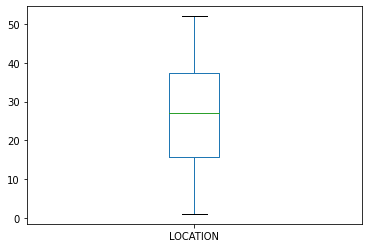

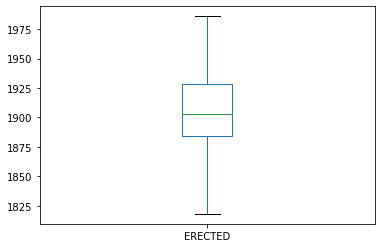

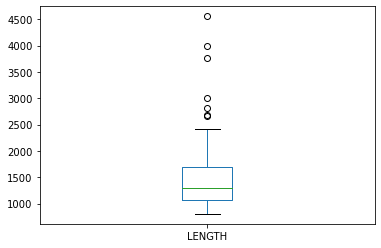

In [139]:
# define a function called "plot_boxplot"

def plot_boxplot(df,ft):   
    df.boxplot(column=[ft])
    plt.grid(False)
    plt.show()    
    
for c in scalar_columns:
    plot_boxplot( df_no_missing, c )

In [140]:
# defining columns with outliers
cols_with_outliers = [ 'LENGTH' ]

In [141]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
#                                                         #
#               Removing "Extreme" Outliers               # 
#                     using "z-values"                    #
#                                                         #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

In [142]:
# define a function called outliers
# which returns a list of index of outliers
# z = (x-M) / SD
# +/- 3    

def outliers(df,ft):
    x  = df[ft]
    M  = x.mean()
    SD = x.std()
    z  = (x-M) / SD
    
    upper_bound = +3
    lower_bound = -3
    
    ls = df.index[  (z > upper_bound) 
                  | (z < lower_bound) ]
    
    return ls

In [143]:
# create a function to store the output indices 
# from multiple columns    
    
index_list = []
for feature in cols_with_outliers:  
    index_list.extend( outliers(df_no_missing,feature) )

In [144]:
# define a function called "remove_extreme_outliers_by_zValues"
# which returns a dataframe without extreme outliers 

def remove_extreme_outliers_by_zValues(df, ls):
    ls = sorted(set(ls))
    df = df.drop(ls)
    return df 

df_extreme    = df_no_missing.iloc[ sorted(index_list), : ]
df_no_extreme = remove_extreme_outliers_by_zValues( df_no_missing, index_list )
len(df_no_extreme)/len(df_raw) *100

97.22222222222221

In [145]:
df_no_extreme.head()

,LOCATION,ERECTED,LENGTH,RIVER,PURPOSE,LANES,CLEAR_G,T_OR_D,MATERIAL,SPAN,REL_L,TYPE
0,3,1818,1300,M,HIGHWAY,2,N,THROUGH,WOOD,SHORT,S,WOOD
1,25,1819,1037,A,HIGHWAY,2,N,THROUGH,WOOD,SHORT,S,WOOD
2,39,1829,1300,A,AQUEDUCT,1,N,THROUGH,WOOD,MEDIUM,S,WOOD
3,29,1837,1000,A,HIGHWAY,2,N,THROUGH,WOOD,SHORT,S,WOOD
4,23,1838,1300,M,HIGHWAY,2,N,THROUGH,WOOD,MEDIUM,S,WOOD


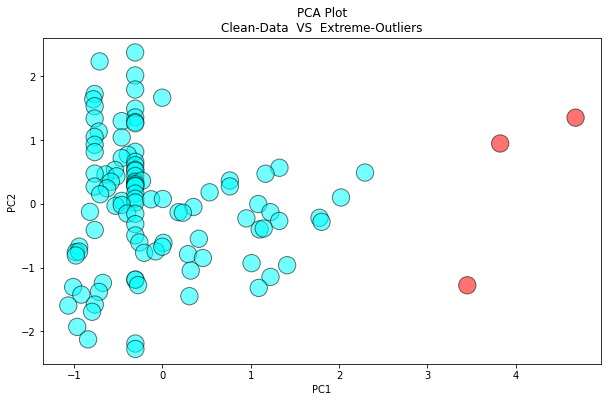

In [146]:
# visualizing extreme outliers
df_dirty = pd.concat([df_no_extreme[scalar_columns],df_extreme[scalar_columns]],axis=0)

flag_clean   = np.ones( df_no_extreme.shape[0] ) * (+1)
flag_outlier = np.ones( df_extreme.shape[0]    ) * (-1) 

flag = list(flag_clean)
for i in list(flag_outlier):
    flag.append(i)

# PCA of Multivariate Outliers
x = df_dirty 
y = []
for i in range(0,len(flag)):
    if flag[i]==1: y.append('cyan')
    else:          y.append('red')

pca = PCA()
pca.fit_transform( x )
 
x_pca = scale( pca.fit_transform( x ) )
x_pc1 = x_pca[:,0] 
x_pc2 = x_pca[:,1] 

# PCA Scatter Plot 
fig, ax = plt.subplots( figsize=(10,6) )  

scatter = ax.scatter( 
      x_pc1
    , x_pc2 
    #, cmap = 'rainbow'
    , c    = y
    , s    = 300
    , edgecolors = 'k'
    , alpha      = 0.55 
    )
 
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA Plot\nClean-Data  VS  Extreme-Outliers')

'''
legend = ax.legend( scatter.legend_elements()[0],
                    scatter.legend_elements()[1],
                    loc='upper right') 
'''

plt.show()

In [147]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
#                                                         #
#            Removing "Multivariate" Outliers             # 
#              using "Mahalanobis Distance"               #
#                                                         #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

In [148]:
# define a function called "MahalanobisDist"
# which returns the Mahalanobis Distance (MD) for each record

def MahalanobisDist(df, verbose=False):
    covariance_matrix = np.cov(df, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            vars_mean = []
            for i in range(df.shape[0]):
                vars_mean.append(list(df.mean(axis=0)))
            diff = df - vars_mean
            md = []
            for i in range(len(diff)):
                md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))

            if verbose:
                print("Covariance Matrix:\n {}\n".format(covariance_matrix))
                print("Inverse of Covariance Matrix:\n {}\n".format(inv_covariance_matrix))
                print("Variables Mean Vector:\n {}\n".format(vars_mean))
                print("Variables - Variables Mean Vector:\n {}\n".format(diff))
                print("Mahalanobis Distance:\n {}\n".format(md))
            return md
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

# finding mahalanobis distance for each record
md = MahalanobisDist(df_no_extreme[scalar_columns].to_numpy(), verbose=0)


# defining a function called "multivar_outliers" 
# which returns list of indexes of multivariate outliers 

def multivar_outliers(df,md):
    #df['MD'] = md
    M  = np.mean(md)
    SD = np.std(md)
    threshhold = M + 3.0*SD
    ls = df.index[  (md > threshhold)  ]
    return ls
 
index_list = multivar_outliers( df_no_extreme[scalar_columns], md )


# define a function called "remove"
# which removes multivariate outliers

def remove_multivar_outliers(df, ls):
    ls = sorted(set(ls))
    df = df.drop(ls)
    return df 

df_no_multivar = remove_multivar_outliers( df_no_extreme, index_list ) 
df_multivar    = df_no_extreme.drop( df_no_multivar.index ) 
len(df_no_multivar)/len(df_raw) *100

97.22222222222221

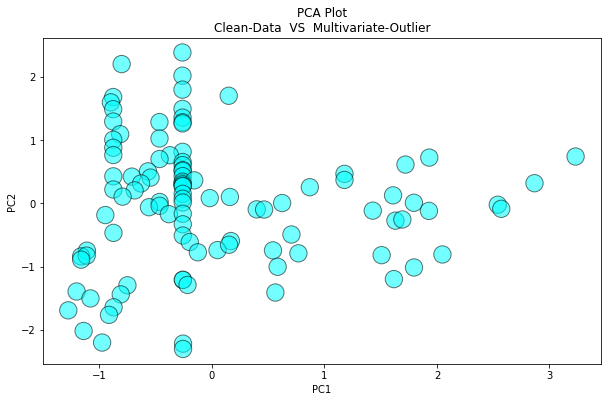

In [149]:
# visualizing multivariate outliers
df_dirty = pd.concat([df_no_multivar[scalar_columns],df_multivar[scalar_columns]],axis=0)

flag_clean   = np.ones( df_no_multivar.shape[0] ) * (+1)
flag_outlier = np.ones( df_multivar.shape[0]    ) * (-1) 

flag = list(flag_clean)
for i in list(flag_outlier):
    flag.append(i)

# PCA of Multivariate Outliers
x = df_dirty 
y = []
for i in range(0,len(flag)):
    if flag[i]==1: y.append('cyan')
    else:          y.append('red')

pca = PCA()
pca.fit_transform( x )
 
x_pca = scale( pca.fit_transform( x ) )
x_pc1 = x_pca[:,0] 
x_pc2 = x_pca[:,1] 

# PCA Scatter Plot 
# Clean VS Multivar
fig, ax = plt.subplots( figsize=(10,6) )  

scatter = ax.scatter( 
      x_pc1
    , x_pc2 
    #, cmap = 'rainbow'
    , c    = y
    , s    = 300
    , edgecolors = 'k'
    , alpha      = 0.55 
    )
 
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA Plot\nClean-Data  VS  Multivariate-Outlier')

'''
legend = ax.legend( scatter.legend_elements()[0],
                    scatter.legend_elements()[1],
                    loc='upper right') 
'''

plt.show()

In [150]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
#                                                         #
#       Cleaning scalar data using Isolation-Forest       # 
#                                                         #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

In [151]:
# define a function called Clean_by_IForest
# to clean 'scalar columns' using 'Isolation Forest'

def remove_outliers_by_IForest( df, sc_cols, c ):
    sc_data = df[ sc_cols ].values
    IForest = IsolationForest( contamination=c ) 
    IForest.fit( sc_data )
    flag_clean = IForest.predict( sc_data ) == +1
    return df.loc[ flag_clean, : ]

df_clean = remove_outliers_by_IForest( df_no_multivar, scalar_columns, 0.039 )   # 3.9% contamination considered
df_noise       = df_no_multivar.drop( df_clean.index )   

len(df_clean)/len(df_raw) *100

92.5925925925926

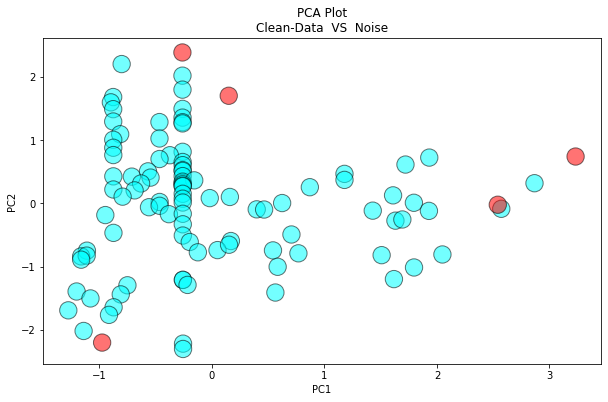

In [152]:
# visualizing multivariate outliers
df_dirty = pd.concat([df_clean[scalar_columns],df_noise[scalar_columns]],axis=0)

flag_clean   = np.ones( df_clean.shape[0] ) * (+1)
flag_outlier = np.ones( df_noise.shape[0] ) * (-1) 

flag = list(flag_clean)
for i in list(flag_outlier):
    flag.append(i)

# PCA of Multivariate Outliers
x = df_dirty 
y = []
for i in range(0,len(flag)):
    if flag[i]==1: y.append('cyan')
    else:          y.append('red')

pca = PCA()
pca.fit_transform( x )
 
x_pca = scale( pca.fit_transform( x ) )
x_pc1 = x_pca[:,0] 
x_pc2 = x_pca[:,1] 

# PCA Scatter Plot 
# Clean VS Multivar
fig, ax = plt.subplots( figsize=(10,6) )  

scatter = ax.scatter( 
      x_pc1
    , x_pc2 
    #, cmap = 'rainbow'
    , c    = y
    , s    = 300
    , edgecolors = 'k'
    , alpha      = 0.55 
    )
 
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA Plot\nClean-Data  VS  Noise')

'''
legend = ax.legend( scatter.legend_elements()[0],
                    scatter.legend_elements()[1],
                    loc='upper right') 
'''

plt.show()

In [154]:
# Checking Cleaned data at each stage

# Outliers    
Outlier_Dict = { 
      'Method'       : ['z-values', 'Mahalanobis_Distance', 'Isolation Forest']
    , 'Outlier_Type' : ['Extreme' , 'Multivariate'        , 'Noise'           ]
    , 'Clean'        : [ len(df_no_extreme), len(df_no_multivar), len(df_clean) ]
    , 'Outlier'      : [ len(df_extreme),    len(df_multivar),    len(df_noise) ] 
    , 'Clean/No_Missing (%)' : [  len(df_no_extreme)/len(df_no_missing)  *100
                                , len(df_no_multivar)/len(df_no_missing) *100
                                , len(df_clean)/len(df_no_missing)       *100 ] }

Outlier = pd.DataFrame( Outlier_Dict ) 
Outlier

,Method,Outlier_Type,Clean,Outlier,Clean/No_Missing (%)
0,z-values,Extreme,105,3,97.222222
1,Mahalanobis_Distance,Multivariate,105,0,97.222222
2,Isolation Forest,Noise,100,5,92.592593


In [155]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
#                                                         #
#             Inspecting the categorical data             # 
#                                                         #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

In [156]:
print( 'Categories:', categorical_columns )

Categories: ['RIVER', 'PURPOSE', 'LANES', 'CLEAR_G', 'T_OR_D', 'MATERIAL', 'SPAN', 'REL_L', 'TYPE']


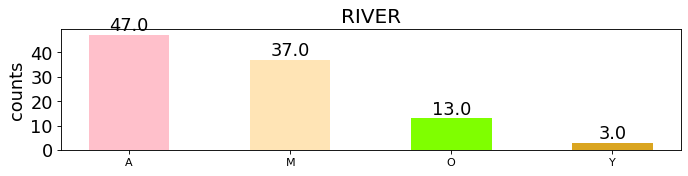

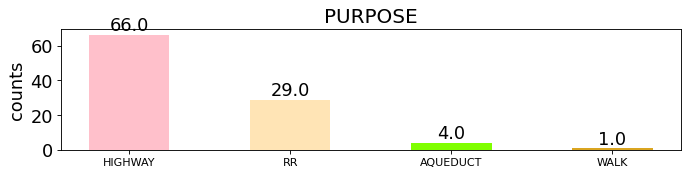

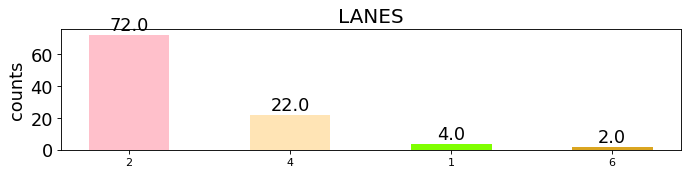

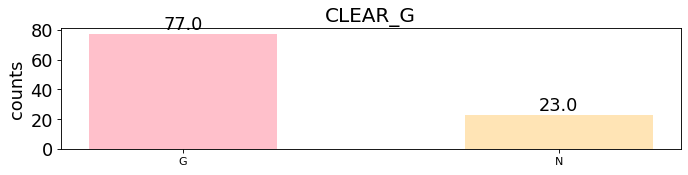

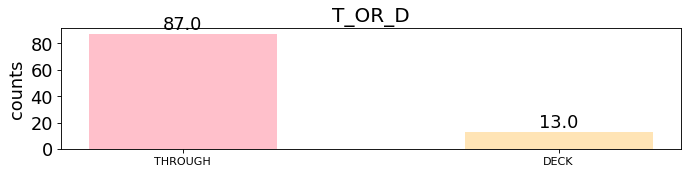

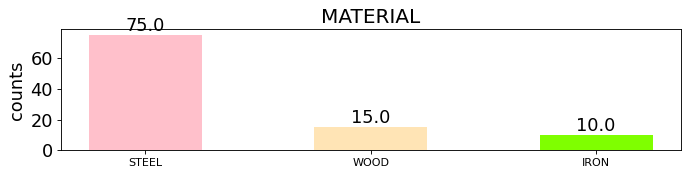

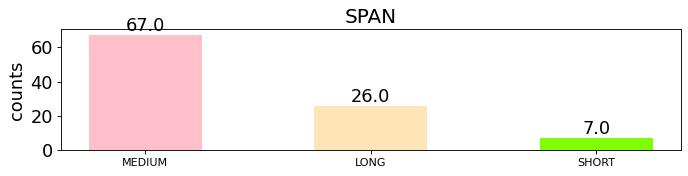

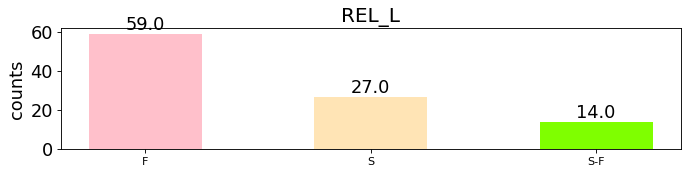

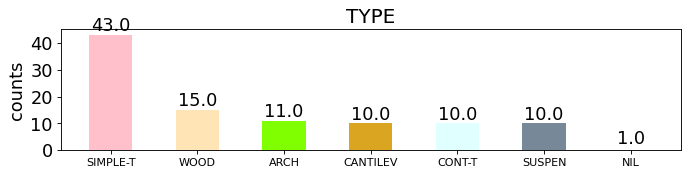

In [157]:
# define a function callled plot_bars
# to show frequency of each item in each category

def plot_bars(df, ft):
    import random
    
    for c in ft:
        # Prepare Data
        S = df.groupby( c ).size().reset_index( name='counts' ) 
        S = S.sort_values('counts',ascending=False)
        n = S[c].unique().__len__()
        all_colors = list( plt.cm.colors.cnames.keys() )
        random.seed(1000)
        colors = random.choices( all_colors, k=n )
        
        # Plot Bars
        plt.figure(figsize=(10,2), dpi= 80)
        plt.bar( S[c], S['counts'], color=colors, width=.5 )
        for i, val in enumerate( S['counts'].values ):
            plt.text(  i, val, float(val)
                     , horizontalalignment='center', verticalalignment='bottom'
                     , fontdict={'fontweight':500, 'size':16}
                    )
 
        # Decoration
        #plt.gca().set_xticklabels( S[c], rotation=0, horizontalalignment='center', fontsize=16 )
        plt.yticks(fontsize=16)
        plt.title( c, fontsize=18)
        plt.ylabel( 'counts', fontsize=16 )
        #plt.ylim(0, 40) 
        #plt.savefig('composition_04v_Bar_Chart.png') 
        plt.show()
         
            
            
plot_bars( df_clean, categorical_columns )

In [158]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
#                                                         #
#                    Downsampling Data                    #
#                                                         #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

In [159]:
# define a function callled count_cats
# to show frequency of each item in each category

def count_cats(df, ft):
    for c in ft:
        S = df[c]
        print( '\n', c, sorted(S.unique()), len(S) )
        for x in sorted( S.unique() ):
            y = S[S==x]
            print( '  ', x, ' ', len(y)) 
            
count_cats( df_clean, [estimated_column] )


 PURPOSE ['AQUEDUCT', 'HIGHWAY', 'RR', 'WALK'] 100
   AQUEDUCT   4
   HIGHWAY   66
   RR   29
   WALK   1


In [162]:
# Using The Estimated Feature to Downsample
df_AQUEDUCT = df_clean[ df_clean['PURPOSE']=='AQUEDUCT' ]  #  4 recordS
df_HIGHWAY  = df_clean[ df_clean['PURPOSE']=='HIGHWAY'  ]  # 66 recordS
df_RR       = df_clean[ df_clean['PURPOSE']=='RR'       ]  # 29 recordS
df_WALK     = df_clean[ df_clean['PURPOSE']=='WALK'     ]  #  1 recordS 

print(  len( df_AQUEDUCT )
      , len( df_HIGHWAY  )
      , len( df_RR       )
      , len( df_WALK     ) ) 

4 66 29 1


In [168]:
# down_sampling  (resize to 80)
df_AQUEDUCT_downsampled = resample( df_AQUEDUCT, replace=False, n_samples=4,  random_state=0 )
df_HIGHWAY_downsampled  = resample( df_HIGHWAY,  replace=False, n_samples=56, random_state=0 )
df_RR_downsampled       = resample( df_RR,       replace=False, n_samples=29, random_state=0 )
df_WALK_downsampled     = resample( df_WALK,     replace=False, n_samples=1,  random_state=0 )

print(  len( df_AQUEDUCT_downsampled )
      , len( df_HIGHWAY_downsampled  )
      , len( df_RR_downsampled       )
      , len( df_WALK_downsampled     ) )

4 56 29 1


In [169]:
# merging down_sampled datasets
df_sample = pd.concat( [  df_AQUEDUCT_downsampled     
                        , df_HIGHWAY_downsampled 
                        , df_RR_downsampled
                        , df_WALK_downsampled     ] )
len( df_sample )  # 90

90

In [58]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
#                                                         #
#                   Formatting the Data                   #
#                                                         #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

In [170]:
# step 1:  defining x & y

x = df_sample.drop( estimated_column, axis=1 ).copy()
y = df_sample[ estimated_column ].copy() 

In [171]:
# step 2: One-Hot Encoding of categorical data on x

x.dtypes

LOCATION     int64
ERECTED      int64
LENGTH       int64
RIVER       object
LANES       object
CLEAR_G     object
T_OR_D      object
MATERIAL    object
SPAN        object
REL_L       object
TYPE        object
dtype: object

In [172]:
encode_columns = []
for ft in categorical_columns:
    if ft not in  [estimated_column]:
        encode_columns.append(ft)
        
encode_columns

['RIVER', 'LANES', 'CLEAR_G', 'T_OR_D', 'MATERIAL', 'SPAN', 'REL_L', 'TYPE']

In [173]:
x_encoded = pd.get_dummies(
      x
    , columns = encode_columns
    )

x_encoded.head()

,LOCATION,ERECTED,LENGTH,RIVER_A,RIVER_M,RIVER_O,RIVER_Y,LANES_1,LANES_2,LANES_4,...,REL_L_F,REL_L_S,REL_L_S-F,TYPE_ARCH,TYPE_CANTILEV,TYPE_CONT-T,TYPE_NIL,TYPE_SIMPLE-T,TYPE_SUSPEN,TYPE_WOOD
8,39,1848,1300,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
38,27,1892,1092,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
6,28,1844,1000,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
2,39,1829,1300,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
83,42,1931,1450,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0


In [199]:
# step 3: training and testing sets 

x_train, x_test, y_train, y_test = train_test_split(
    x_encoded, y, random_state=0 ,test_size=( 10/len(df_sample) ) 
    )

In [200]:
# step 4: scaling x
x_train_scaled = scale( x_train )
x_test_scaled  = scale( x_test  ) 

In [201]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
#                                                         #
#             Building a preliminary Xg Boost             #
#                   for Classification                    #
#                                                         #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

In [202]:
# XgBoost Classifier 
print('\nXgBoost ...') 
xgb_clf = XGBClassifier( )
xgb_clf.fit( x_train_scaled, y_train )

# checking saccuracy
y_pred = xgb_clf.predict( x_test_scaled )
accuracy = accuracy_score(y_test,y_pred)
print( '\naccuracy = ', accuracy )


XgBoost ...


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:03:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

accuracy =  0.7


In [203]:
# finding parameters
print( xgb_clf )

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)


In [204]:
# studying parameters
'''
xgb_parameters = [
      base_score         =  0.5
    , booster            = 'gbtree'
    , colsample_bylevel  =  1
    , colsample_bynode   =  1
    , colsample_bytree   =  1
    , enable_categorical =  False
    , gamma              =  0
    , gpu_id             = -1
    , importance_type    =  None
    , interaction_constraints = ''
    , learning_rate      =  0.3
    , max_delta_step     =  0
    , max_depth          =  6
    , min_child_weight   =  1
    , missing            =  nan
    , monotone_constraints = '()'
    , n_estimators       =  100
    , n_jobs             =  4
    , num_parallel_tree  =  1
    , objective          = 'multi:softprob'
    , predictor          = 'auto'
    , random_state       =  0
    , reg_alpha          =  0
    , reg_lambda         =  1
    , scale_pos_weight   =  None
    , subsample          =  1
    , tree_method        = 'exact'
    , validate_parameters = 1
    , verbosity          =  None
    ]
'''

"\nxgb_parameters = [\n      base_score         =  0.5\n    , booster            = 'gbtree'\n    , colsample_bylevel  =  1\n    , colsample_bynode   =  1\n    , colsample_bytree   =  1\n    , enable_categorical =  False\n    , gamma              =  0\n    , gpu_id             = -1\n    , importance_type    =  None\n    , interaction_constraints = ''\n    , learning_rate      =  0.3\n    , max_delta_step     =  0\n    , max_depth          =  6\n    , min_child_weight   =  1\n    , missing            =  nan\n    , monotone_constraints = '()'\n    , n_estimators       =  100\n    , n_jobs             =  4\n    , num_parallel_tree  =  1\n    , objective          = 'multi:softprob'\n    , predictor          = 'auto'\n    , random_state       =  0\n    , reg_alpha          =  0\n    , reg_lambda         =  1\n    , scale_pos_weight   =  None\n    , subsample          =  1\n    , tree_method        = 'exact'\n    , validate_parameters = 1\n    , verbosity          =  None\n    ]\n"

In [219]:
# Optimize Parameters with Cross Validation and GridSearchCV()

param_grid = [ 
       {'base_score'   : [ .20, .25, .03, .35, .40, .45, .50 ],
        'eta'          : [ .03, .05, .10, .20 ], 
        'max_depth'    : [   1,   2,   3,   4, 5, 6 ],
        'n_estimators' : [   5                ]       
        },
    ]

optimal_params = GridSearchCV(
       XGBClassifier(),
       param_grid,
       cv=4,
       scoring='accuracy',
       verbose=2
    )

optimal_params.fit( x_train_scaled, y_train )
print(optimal_params.best_params_)
#Depth_Best = optimal_params.best_params_['max_depth'] 
 

Fitting 4 folds for each of 168 candidates, totalling 672 fits
[CV] base_score=0.2, eta=0.03, max_depth=1, n_estimators=5 ...........
[03:11:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.2, eta=0.03, max_depth=1, n_estimators=5, total=   0.1s

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] base_score=0.2, eta=0.03, max_depth=1, n_estimators=5 ...........
[03:11:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.2, eta=0.03, max_depth=1, n_estimators=5, total=   0.2s
[CV] base_score=0.2, eta=0.03, max_depth=1, n_estimators=5 ...........
[03:11:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.2, eta=0.03, max_depth=1, n_estimators=5, total=   0.1s
[CV] base_score=0.2, eta=0.03, max_depth=1, n_estimators=5 ...........
[03:11:52] WAR

[03:11:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.2, eta=0.03, max_depth=6, n_estimators=5, total=   0.2s
[CV] base_score=0.2, eta=0.03, max_depth=6, n_estimators=5 ...........
[03:11:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.2, eta=0.03, max_depth=6, n_estimators=5, total=   1.5s
[CV] base_score=0.2, eta=0.03, max_depth=6, n_estimators=5 ...........
[03:11:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/l

[CV] base_score=0.2, eta=0.05, max_depth=5, n_estimators=5 ...........
[03:12:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.2, eta=0.05, max_depth=5, n_estimators=5, total=   0.1s
[CV] base_score=0.2, eta=0.05, max_depth=5, n_estimators=5 ...........
[03:12:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.2, eta=0.05, max_depth=5, n_estimators=5, total=   0.1s
[CV] base_score=0.2, eta=0.05, max_depth=5, n_estimators=5 ...........
[03:12:00] WARN

[03:12:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.2, eta=0.1, max_depth=3, n_estimators=5, total=   0.2s
[CV] base_score=0.2, eta=0.1, max_depth=3, n_estimators=5 ............
[03:12:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.2, eta=0.1, max_depth=3, n_estimators=5, total=   0.6s
[CV] base_score=0.2, eta=0.1, max_depth=4, n_estimators=5 ............
[03:12:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/lea

[03:12:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.2, eta=0.2, max_depth=2, n_estimators=5, total=   0.8s
[CV] base_score=0.2, eta=0.2, max_depth=2, n_estimators=5 ............
[03:12:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.2, eta=0.2, max_depth=2, n_estimators=5, total=   0.1s
[CV] base_score=0.2, eta=0.2, max_depth=3, n_estimators=5 ............
[03:12:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/lea

[CV]  base_score=0.25, eta=0.03, max_depth=1, n_estimators=5, total=   0.2s
[CV] base_score=0.25, eta=0.03, max_depth=1, n_estimators=5 ..........
[03:12:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.25, eta=0.03, max_depth=1, n_estimators=5, total=   0.2s
[CV] base_score=0.25, eta=0.03, max_depth=1, n_estimators=5 ..........
[03:12:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.25, eta=0.03, max_depth=1, n_estimators=5, total=   0.4s
[CV] bas

[CV]  base_score=0.25, eta=0.03, max_depth=5, n_estimators=5, total=   0.2s
[CV] base_score=0.25, eta=0.03, max_depth=6, n_estimators=5 ..........
[03:12:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.25, eta=0.03, max_depth=6, n_estimators=5, total=   0.1s
[CV] base_score=0.25, eta=0.03, max_depth=6, n_estimators=5 ..........
[03:12:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.25, eta=0.03, max_depth=6, n_estimators=5, total=   0.1s
[CV] bas

[CV]  base_score=0.25, eta=0.05, max_depth=4, n_estimators=5, total=   1.2s
[CV] base_score=0.25, eta=0.05, max_depth=4, n_estimators=5 ..........
[03:12:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.25, eta=0.05, max_depth=4, n_estimators=5, total=   0.1s
[CV] base_score=0.25, eta=0.05, max_depth=4, n_estimators=5 ..........
[03:12:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.25, eta=0.05, max_depth=4, n_estimators=5, total=   0.2s
[CV] bas

[CV] base_score=0.25, eta=0.1, max_depth=3, n_estimators=5 ...........
[03:12:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.25, eta=0.1, max_depth=3, n_estimators=5, total=   0.1s
[CV] base_score=0.25, eta=0.1, max_depth=3, n_estimators=5 ...........
[03:12:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.25, eta=0.1, max_depth=3, n_estimators=5, total=   0.2s
[CV] base_score=0.25, eta=0.1, max_depth=3, n_estimators=5 ...........
[03:12:24] WARN

[CV]  base_score=0.25, eta=0.2, max_depth=1, n_estimators=5, total=   0.2s
[CV] base_score=0.25, eta=0.2, max_depth=2, n_estimators=5 ...........
[03:12:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.25, eta=0.2, max_depth=2, n_estimators=5, total=   2.9s
[CV] base_score=0.25, eta=0.2, max_depth=2, n_estimators=5 ...........
[03:12:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.25, eta=0.2, max_depth=2, n_estimators=5, total=   0.1s
[CV] base_s

[CV]  base_score=0.25, eta=0.2, max_depth=6, n_estimators=5, total=   0.2s
[CV] base_score=0.25, eta=0.2, max_depth=6, n_estimators=5 ...........
[03:12:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.25, eta=0.2, max_depth=6, n_estimators=5, total=   0.2s
[CV] base_score=0.03, eta=0.03, max_depth=1, n_estimators=5 ..........
[03:12:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.03, eta=0.03, max_depth=1, n_estimators=5, total=   0.1s
[CV] base_

[CV]  base_score=0.03, eta=0.03, max_depth=5, n_estimators=5, total=   0.1s
[CV] base_score=0.03, eta=0.03, max_depth=5, n_estimators=5 ..........
[03:12:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.03, eta=0.03, max_depth=5, n_estimators=5, total=   0.2s
[CV] base_score=0.03, eta=0.03, max_depth=5, n_estimators=5 ..........
[03:12:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.03, eta=0.03, max_depth=5, n_estimators=5, total=   0.2s
[CV] bas

[CV]  base_score=0.03, eta=0.05, max_depth=4, n_estimators=5, total=   0.2s
[CV] base_score=0.03, eta=0.05, max_depth=4, n_estimators=5 ..........
[03:12:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.03, eta=0.05, max_depth=4, n_estimators=5, total=   0.1s
[CV] base_score=0.03, eta=0.05, max_depth=4, n_estimators=5 ..........
[03:12:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.03, eta=0.05, max_depth=4, n_estimators=5, total=   0.1s
[CV] bas

[03:12:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.03, eta=0.1, max_depth=3, n_estimators=5, total=   0.2s
[CV] base_score=0.03, eta=0.1, max_depth=3, n_estimators=5 ...........
[03:12:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.03, eta=0.1, max_depth=3, n_estimators=5, total=   0.4s
[CV] base_score=0.03, eta=0.1, max_depth=3, n_estimators=5 ...........
[03:12:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/l

[03:13:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.03, eta=0.2, max_depth=1, n_estimators=5, total=   0.2s
[CV] base_score=0.03, eta=0.2, max_depth=2, n_estimators=5 ...........
[03:13:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.03, eta=0.2, max_depth=2, n_estimators=5, total=   0.2s
[CV] base_score=0.03, eta=0.2, max_depth=2, n_estimators=5 ...........
[03:13:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/l

[03:13:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.03, eta=0.2, max_depth=6, n_estimators=5, total=   0.1s
[CV] base_score=0.03, eta=0.2, max_depth=6, n_estimators=5 ...........
[03:13:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.03, eta=0.2, max_depth=6, n_estimators=5, total=   0.2s
[CV] base_score=0.03, eta=0.2, max_depth=6, n_estimators=5 ...........
[03:13:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/l

[03:13:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.35, eta=0.03, max_depth=4, n_estimators=5, total=   0.4s
[CV] base_score=0.35, eta=0.03, max_depth=5, n_estimators=5 ..........
[03:13:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.35, eta=0.03, max_depth=5, n_estimators=5, total=   0.1s
[CV] base_score=0.35, eta=0.03, max_depth=5, n_estimators=5 ..........
[03:13:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src

[03:13:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.35, eta=0.05, max_depth=3, n_estimators=5, total=   0.2s
[CV] base_score=0.35, eta=0.05, max_depth=3, n_estimators=5 ..........
[03:13:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.35, eta=0.05, max_depth=3, n_estimators=5, total=   0.1s
[CV] base_score=0.35, eta=0.05, max_depth=3, n_estimators=5 ..........
[03:13:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src

[CV]  base_score=0.35, eta=0.1, max_depth=2, n_estimators=5, total=   0.2s
[CV] base_score=0.35, eta=0.1, max_depth=2, n_estimators=5 ...........
[03:13:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.35, eta=0.1, max_depth=2, n_estimators=5, total=   0.2s
[CV] base_score=0.35, eta=0.1, max_depth=2, n_estimators=5 ...........
[03:13:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.35, eta=0.1, max_depth=2, n_estimators=5, total=   0.1s
[CV] base_s

[CV]  base_score=0.35, eta=0.1, max_depth=6, n_estimators=5, total=   0.2s
[CV] base_score=0.35, eta=0.1, max_depth=6, n_estimators=5 ...........
[03:13:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.35, eta=0.1, max_depth=6, n_estimators=5, total=   0.2s
[CV] base_score=0.35, eta=0.2, max_depth=1, n_estimators=5 ...........
[03:13:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.35, eta=0.2, max_depth=1, n_estimators=5, total=   0.1s
[CV] base_s

[CV] base_score=0.35, eta=0.2, max_depth=5, n_estimators=5 ...........
[03:13:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.35, eta=0.2, max_depth=5, n_estimators=5, total=   0.4s
[CV] base_score=0.35, eta=0.2, max_depth=5, n_estimators=5 ...........
[03:13:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.35, eta=0.2, max_depth=5, n_estimators=5, total=   0.1s
[CV] base_score=0.35, eta=0.2, max_depth=5, n_estimators=5 ...........
[03:13:28] WARN

[03:13:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.4, eta=0.03, max_depth=3, n_estimators=5, total=   0.2s
[CV] base_score=0.4, eta=0.03, max_depth=4, n_estimators=5 ...........
[03:13:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.4, eta=0.03, max_depth=4, n_estimators=5, total=   0.2s
[CV] base_score=0.4, eta=0.03, max_depth=4, n_estimators=5 ...........
[03:13:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/l

[CV]  base_score=0.4, eta=0.05, max_depth=2, n_estimators=5, total=   0.9s
[CV] base_score=0.4, eta=0.05, max_depth=2, n_estimators=5 ...........
[03:13:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.4, eta=0.05, max_depth=2, n_estimators=5, total=   0.1s
[CV] base_score=0.4, eta=0.05, max_depth=2, n_estimators=5 ...........
[03:13:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.4, eta=0.05, max_depth=2, n_estimators=5, total=   0.1s
[CV] base_s

[CV]  base_score=0.4, eta=0.05, max_depth=6, n_estimators=5, total=   0.2s
[CV] base_score=0.4, eta=0.1, max_depth=1, n_estimators=5 ............
[03:13:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.4, eta=0.1, max_depth=1, n_estimators=5, total=   0.2s
[CV] base_score=0.4, eta=0.1, max_depth=1, n_estimators=5 ............
[03:13:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.4, eta=0.1, max_depth=1, n_estimators=5, total=   0.2s
[CV] base_sco

[CV]  base_score=0.4, eta=0.1, max_depth=5, n_estimators=5, total=   0.2s
[CV] base_score=0.4, eta=0.1, max_depth=5, n_estimators=5 ............
[03:13:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.4, eta=0.1, max_depth=5, n_estimators=5, total=   0.3s
[CV] base_score=0.4, eta=0.1, max_depth=5, n_estimators=5 ............
[03:13:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.4, eta=0.1, max_depth=5, n_estimators=5, total=   0.1s
[CV] base_scor

[CV]  base_score=0.4, eta=0.2, max_depth=4, n_estimators=5, total=   0.1s
[CV] base_score=0.4, eta=0.2, max_depth=4, n_estimators=5 ............
[03:13:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.4, eta=0.2, max_depth=4, n_estimators=5, total=   0.2s
[CV] base_score=0.4, eta=0.2, max_depth=4, n_estimators=5 ............
[03:13:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.4, eta=0.2, max_depth=4, n_estimators=5, total=   0.1s
[CV] base_scor

[03:13:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.45, eta=0.03, max_depth=2, n_estimators=5, total=   0.2s
[CV] base_score=0.45, eta=0.03, max_depth=3, n_estimators=5 ..........
[03:13:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.45, eta=0.03, max_depth=3, n_estimators=5, total=   0.2s
[CV] base_score=0.45, eta=0.03, max_depth=3, n_estimators=5 ..........
[03:13:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src

[CV]  base_score=0.45, eta=0.05, max_depth=1, n_estimators=5, total=   0.1s
[CV] base_score=0.45, eta=0.05, max_depth=1, n_estimators=5 ..........
[03:13:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.45, eta=0.05, max_depth=1, n_estimators=5, total=   0.2s
[CV] base_score=0.45, eta=0.05, max_depth=2, n_estimators=5 ..........
[03:13:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.45, eta=0.05, max_depth=2, n_estimators=5, total=   0.1s
[CV] bas

[CV]  base_score=0.45, eta=0.05, max_depth=6, n_estimators=5, total=   0.2s
[CV] base_score=0.45, eta=0.05, max_depth=6, n_estimators=5 ..........
[03:13:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.45, eta=0.05, max_depth=6, n_estimators=5, total=   0.2s
[CV] base_score=0.45, eta=0.05, max_depth=6, n_estimators=5 ..........
[03:13:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.45, eta=0.05, max_depth=6, n_estimators=5, total=   0.2s
[CV] bas

[CV] base_score=0.45, eta=0.1, max_depth=4, n_estimators=5 ...........
[03:14:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.45, eta=0.1, max_depth=4, n_estimators=5, total=   0.2s
[CV] base_score=0.45, eta=0.1, max_depth=5, n_estimators=5 ...........
[03:14:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.45, eta=0.1, max_depth=5, n_estimators=5, total=   0.1s
[CV] base_score=0.45, eta=0.1, max_depth=5, n_estimators=5 ...........
[03:14:02] WARN

[03:14:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.45, eta=0.2, max_depth=3, n_estimators=5, total=   0.1s
[CV] base_score=0.45, eta=0.2, max_depth=3, n_estimators=5 ...........
[03:14:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.45, eta=0.2, max_depth=3, n_estimators=5, total=   0.2s
[CV] base_score=0.45, eta=0.2, max_depth=4, n_estimators=5 ...........
[03:14:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/l

[CV]  base_score=0.5, eta=0.03, max_depth=2, n_estimators=5, total=   0.1s
[CV] base_score=0.5, eta=0.03, max_depth=2, n_estimators=5 ...........
[03:14:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.5, eta=0.03, max_depth=2, n_estimators=5, total=   0.1s
[CV] base_score=0.5, eta=0.03, max_depth=2, n_estimators=5 ...........
[03:14:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.5, eta=0.03, max_depth=2, n_estimators=5, total=   0.1s
[CV] base_s

[CV]  base_score=0.5, eta=0.03, max_depth=6, n_estimators=5, total=   0.1s
[CV] base_score=0.5, eta=0.05, max_depth=1, n_estimators=5 ...........
[03:14:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.5, eta=0.05, max_depth=1, n_estimators=5, total=   0.1s
[CV] base_score=0.5, eta=0.05, max_depth=1, n_estimators=5 ...........
[03:14:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.5, eta=0.05, max_depth=1, n_estimators=5, total=   0.1s
[CV] base_s

[CV]  base_score=0.5, eta=0.05, max_depth=5, n_estimators=5, total=   0.1s
[CV] base_score=0.5, eta=0.05, max_depth=5, n_estimators=5 ...........
[03:14:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.5, eta=0.05, max_depth=5, n_estimators=5, total=   0.1s
[CV] base_score=0.5, eta=0.05, max_depth=5, n_estimators=5 ...........
[03:14:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.5, eta=0.05, max_depth=5, n_estimators=5, total=   0.1s
[CV] base_s

[CV]  base_score=0.5, eta=0.1, max_depth=3, n_estimators=5, total=   0.1s
[CV] base_score=0.5, eta=0.1, max_depth=4, n_estimators=5 ............
[03:14:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.5, eta=0.1, max_depth=4, n_estimators=5, total=   0.1s
[CV] base_score=0.5, eta=0.1, max_depth=4, n_estimators=5 ............
[03:14:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.5, eta=0.1, max_depth=4, n_estimators=5, total=   0.1s
[CV] base_scor

[CV]  base_score=0.5, eta=0.2, max_depth=2, n_estimators=5, total=   0.1s
[CV] base_score=0.5, eta=0.2, max_depth=2, n_estimators=5 ............
[03:14:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.5, eta=0.2, max_depth=2, n_estimators=5, total=   0.1s
[CV] base_score=0.5, eta=0.2, max_depth=3, n_estimators=5 ............
[03:14:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  base_score=0.5, eta=0.2, max_depth=3, n_estimators=5, total=   0.1s
[CV] base_scor

[Parallel(n_jobs=1)]: Done 672 out of 672 | elapsed:  2.7min finished


[03:14:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'base_score': 0.2, 'eta': 0.1, 'max_depth': 5, 'n_estimators': 5}


In [206]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
#                                                         #
#             Building an Optimized Xg Boost              #
#                   for Classification                    #
#                                                         #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

In [228]:
# XgBoost Classifier 
print('\nXgBoost ...') 
xgb_clf = XGBClassifier(
      base_score    = 0.2
    , learning_rate = 0.1
    , max_depth     = 5
    , n_estimators  = 50 )
xgb_clf.fit( x_train_scaled, y_train )

# checking saccuracy
y_pred = xgb_clf.predict( x_test_scaled )
accuracy = accuracy_score(y_test,y_pred)
print( '\naccuracy = ', accuracy )


XgBoost ...
[03:16:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

accuracy =  0.7


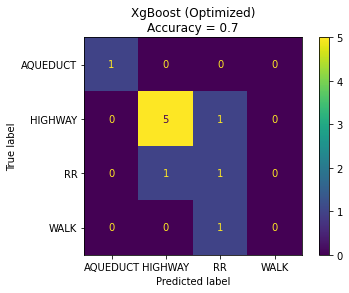

In [229]:
# plotting confusion matrix

plot_confusion_matrix( 
    xgb_clf, 
    x_test_scaled, y_test, 
    values_format='d', 
    display_labels=( sorted(df_clean[ estimated_column ].unique()) )
    )
plt.title('XgBoost (Optimized)\nAccuracy = ' + str(np.round(accuracy,3)))
#plt.savefig('CMatrix_DTree.png', dpi=240)
plt.show()

In [230]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
#                                                         #
#               Preparing to make predictions             #
#                                                         #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

In [231]:
print('\n Acceptable Range ... \n')

# Range of scalar_columns
Range = pd.concat([df_clean[scalar_columns].min(),df_clean[scalar_columns].max()],axis=1)
Range.columns = ['Min','Max']
print( np.round( Range, 2 ), '\n' )

# Range of categorical_columns
for col in categorical_columns:
    items = sorted( df_clean[ col ].unique() )
    print( col, '   ', items )


 Acceptable Range ... 

           Min   Max
LOCATION     1    52
ERECTED   1819  1986
LENGTH     804  2822 

RIVER     ['A', 'M', 'O', 'Y']
PURPOSE     ['AQUEDUCT', 'HIGHWAY', 'RR', 'WALK']
LANES     ['1', '2', '4', '6']
CLEAR_G     ['G', 'N']
T_OR_D     ['DECK', 'THROUGH']
MATERIAL     ['IRON', 'STEEL', 'WOOD']
SPAN     ['LONG', 'MEDIUM', 'SHORT']
REL_L     ['F', 'S', 'S-F']
TYPE     ['ARCH', 'CANTILEV', 'CONT-T', 'NIL', 'SIMPLE-T', 'SUSPEN', 'WOOD']


In [232]:
# input data for Bridge to predict its MATERIAL

# Item                          Range
LOCATION = 3             #     1    51
ERECTED  = 1818          #  1818  1986
LENGTH   = 3000          #   804  4000 

RIVER    = 'M'           #        'A'        'M'      'O'     'Y'
#PURPOSE = xxx           #              To Be Estimated
LANES    = '2'           #        '1'        '2'      '4'     '6'
CLEAR_G  = 'N'           #        'G'        'N'
T_OR_D   = 'THROUGH'     #     'DECK'  'THROUGH'
MATERIAL = 'WOOD'        #     'IRON'    'STEEL'   'WOOD'
SPAN     = 'SHORT'       #     'LONG'   'MEDIUM'  'SHORT'
REL_L    = 'S'           #        'F'        'S'    'S-F'
TYPE     = 'WOOD'        #     'ARCH' 'CANTILEV' 'CONT-T' 'NIL' 'SIMPLE-T' 'SUSPEN' 'WOOD'

# s  written in the same order as  x
s = [ LOCATION, ERECTED, LENGTH, RIVER, LANES, CLEAR_G, T_OR_D, MATERIAL, SPAN, REL_L, TYPE ]

# define a function called predicted_class
# which returns a string of the predicted class
def predicted_class( s, x, encode_columns ):
    s  = pd.DataFrame( [s.copy(),s.copy()], columns=x.columns )
    sx = pd.concat( [s,x], axis=0 )
    sx_encoded = pd.get_dummies(
          sx
        , columns = encode_columns
        )
    sx_scaled = scale( sx_encoded )
    Estimation = xgb_clf.predict( sx_scaled )[0] 
    
    return Estimation    

pred = predicted_class( s, x, encode_columns )
print('The', estimated_column, 'is', pred ) 

The PURPOSE is HIGHWAY
